In [16]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from wordcloud import WordCloud

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from xgboost import XGBClassifier

import pickle
import time

[nltk_data] Downloading package punkt to /Users/vladimir/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vladimir/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vladimir/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load data

In [17]:
gossipcop_f = pd.read_csv("dataset/FakeNewsNet/gossipcop_fake.csv")
gossipcop_r = pd.read_csv("dataset/FakeNewsNet/gossipcop_real.csv")

politifact_f = pd.read_csv("dataset/FakeNewsNet/politifact_fake.csv")
politifact_r = pd.read_csv("dataset/FakeNewsNet/politifact_real.csv")

In [18]:
print(gossipcop_f.shape) #Samples related to fake news collected from GossipCop
print(gossipcop_r.shape) #Samples related to real news collected from GossipCop
print(politifact_f.shape) #Samples related to fake news collected from PolitiFact
print(politifact_r.shape) #Samples related to real news collected from PolitiFact

(5323, 4)
(16817, 4)
(432, 4)
(624, 4)


In [19]:
gossipcop_f.head(2)

,id,news_url,title,tweet_ids
0,gossipcop-2493749932,www.dailymail.co.uk/tvshowbiz/article-5874213/...,Did Miley Cyrus and Liam Hemsworth secretly ge...,284329075902926848\t284332744559968256\t284335...
1,gossipcop-4580247171,hollywoodlife.com/2018/05/05/paris-jackson-car...,Paris Jackson & Cara Delevingne Enjoy Night Ou...,992895508267130880\t992897935418503169\t992899...


In [20]:
politifact_f.head(2)

,id,news_url,title,tweet_ids
0,politifact15014,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,937349434668498944\t937379378006282240\t937380...
1,politifact15156,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,972666281441878016\t972678396575559680\t972827...


### Reorder data

In [21]:
# first merge only fake/real news and label them

fake_news = pd.concat([gossipcop_f['title'], politifact_f['title']], ignore_index = True)
fake_news = fake_news.to_frame(name='title') #convert Series to DataFrame

fake_news['news_class'] = 0
print("Fake news shape: ",fake_news.shape)

real_news = pd.concat([gossipcop_r['title'], politifact_r['title']], ignore_index = True)
real_news = real_news.to_frame(name='title') 

real_news['news_class'] = 1
print("Real news shape: ",real_news.shape)

Fake news shape:  (5755, 2)
Real news shape:  (17441, 2)


In [22]:
data = pd.concat([fake_news, real_news], ignore_index=True)
data

,title,news_class
0,Did Miley Cyrus and Liam Hemsworth secretly ge...,0
1,Paris Jackson & Cara Delevingne Enjoy Night Ou...,0
2,Celebrities Join Tax March in Protest of Donal...,0
3,Cindy Crawford's daughter Kaia Gerber wears a ...,0
4,Full List of 2018 Oscar Nominations – Variety,0
...,...,...
23191,Flake: “Religious tests should have no place i...,1
23192,Change We Can Believe In,1
23193,deputy director of national health statistics ...,1
23194,Romneys ProLife Conversion Myth or Reality Jun...,1


In [23]:
# data[data['news_class'] == 0]['title'].to_csv('FakeText_before.csv', index=False)
# data[data['news_class'] == 1]['title'].to_csv('RealText_before.csv', index=False)

### Visualize data

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23196 entries, 0 to 23195
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       23196 non-null  object
 1   news_class  23196 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 362.6+ KB


In [25]:
data.isna().sum()  # Count NaN values

title         0
news_class    0
dtype: int64

<AxesSubplot:title={'center':'Target class'}>

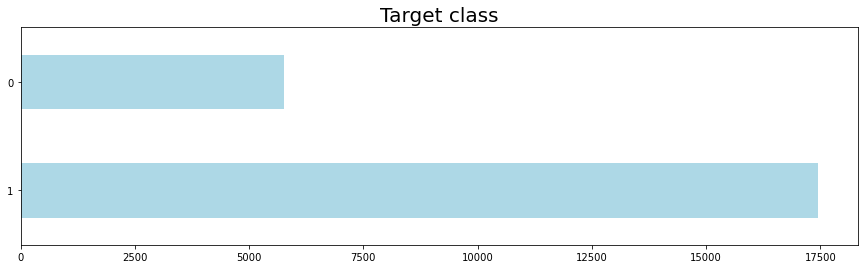

In [26]:
plt.figure(figsize=(15,4))
plt.title('Target class', fontdict={'fontsize': 20})
data['news_class'].value_counts().plot.barh(color = 'lightblue')

In [27]:
data_fake = data[data['news_class']==0]
fake_text = []
for line in data_fake['title']:
    fake_text.append(line)  # Izvlacimo tekstove sa negativnim sentimentom

data_real = data[data['news_class']==1]
real_text = []
for line in data_real['title']:
    real_text.append(line)  # Izvlacimo tekstove sa pozitivnim sentimentom

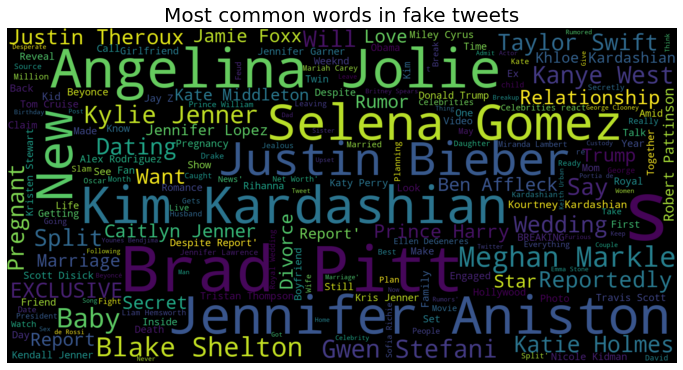

In [28]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(str(fake_text))
plt.figure(figsize=(12,10))
plt.title("Most common words in fake tweets",fontdict={'fontsize':20})
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

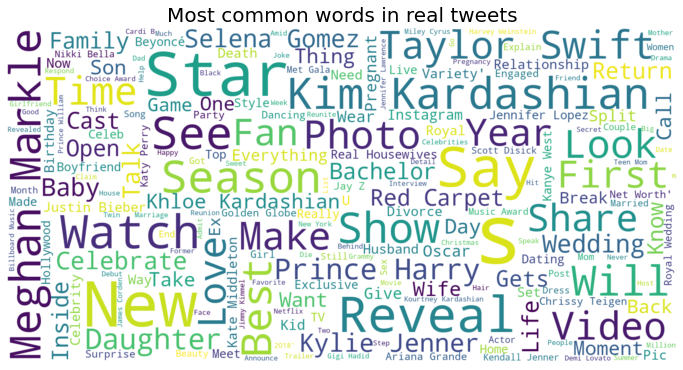

In [29]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, background_color='white').generate(str(real_text))
plt.figure(figsize=(12,10))
plt.title("Most common words in real tweets",fontdict={'fontsize':20})
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Text preprocessing

This part of project is unusual because big part of differences between fake and real tweets can be the text that we clean up with following steps. Probaby best practice will be to include some of this techniques, definitly not all of them.

In [15]:
# data.head(5)

In [16]:
# #lowercase
# data['title'] = data['title'].str.lower() 
# #tokenization of words
# data['title'] = data.apply(lambda row: word_tokenize(row['title']), axis=1) 
# #only alphanumerical values
# data['title'] = data['title'].apply(lambda x: [item for item in x if item.isalpha()]) 
# #stemming words
# data['title'] = data['title'].apply(lambda x : [PorterStemmer().stem(y) for y in x])
# #lemmatazing words
# data['title'] = data['title'].apply(lambda x : [WordNetLemmatizer().lemmatize(y) for y in x])
# #removing useless words
# stop = stopwords.words('english')
# data['title'] = data['title'].apply(lambda x: [item for item in x if item not in stop])

# #We want to make sequencies from list of words, because CountVect receive sequences
# tmp = []
# for row in data['title']:
#     tmp_string = ' '.join(row)
#     tmp.append(tmp_string)
    
# data['title'] = tmp

In [17]:
# data.head(5)

In [18]:
# data[data['news_class'] == 0]['title'].to_csv('FakeText_after.csv', index=False)
# data[data['news_class'] == 1]['title'].to_csv('RealText_after.csv', index=False)

### Split data

In [12]:
y = data['news_class']
x = data['title']

print(x.shape, y.shape)

(23196,) (23196,)


In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

print(x_train.shape[0], x_test.shape[0])

18556 4640


### Count Vectorizer

In [14]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,1), min_df=2, max_df=0.5)
# Default: analyzer='word', ngram_range=(1,1), min_df=1, max_df=1
vectorizer.fit(x_train)

CountVectorizer(max_df=0.5, min_df=2)

In [22]:
x_train = vectorizer.transform(x_train)
x_test = vectorizer.transform(x_test)

print("In training set we have {} sentices with {} words".format(x_train.shape[0], x_train.shape[1]))
print("In test set we have {} recenica with {} words".format(x_test.shape[0], x_test.shape[1]))

In training set we have 18556 sentices with 9320 words
In test set we have 4640 recenica with 9320 words


### Linear SVM

In [26]:
model_svm = svm.SVC(kernel='linear')

start = time.time()
model_svm.fit(x_train, y_train)
end = time.time()

print("Train time in minutes: ",((end-start)/60))

Train time in minutes:  0.6254239161809285


In [27]:
y_train_predict_SVM = model_svm.predict(x_train)
y_test_predict_SVM = model_svm.predict(x_test)

In [28]:
print(classification_report(y_train, y_train_predict_SVM))
print(classification_report(y_test, y_test_predict_SVM))

              precision    recall  f1-score   support

           0       0.93      0.83      0.88      4604
           1       0.95      0.98      0.96     13952

    accuracy                           0.94     18556
   macro avg       0.94      0.91      0.92     18556
weighted avg       0.94      0.94      0.94     18556

              precision    recall  f1-score   support

           0       0.69      0.59      0.64      1151
           1       0.87      0.91      0.89      3489

    accuracy                           0.83      4640
   macro avg       0.78      0.75      0.77      4640
weighted avg       0.83      0.83      0.83      4640



In [23]:
cm_train = confusion_matrix(y_train, y_train_predict_SVM)
cm_test = confusion_matrix(y_test, y_test_predict_SVM)
print("Train:\n", cm_train, "\nTest:\n", cm_test)

Train:
 [[ 4042   562]
 [  230 13722]] 
Test:
 [[ 686  465]
 [ 313 3176]]


In [37]:
print("On train set: \n")
print('F1 score (average=None): ',f1_score(y_train, y_train_predict_SVM, average=None))
print('F1 score (average="micro"): ',f1_score(y_train, y_train_predict_SVM, average="micro"))
print('F1 score (average="macro"): ',f1_score(y_train, y_train_predict_SVM, average="macro"))
print('F1 score (average="weighted"): ',f1_score(y_train, y_train_predict_SVM, average="weighted"))

print("On test set: \n")
print('F1 score (average=None): ',f1_score(y_test, y_test_predict_SVM, average=None))
print('F1 score (average="micro"): ',f1_score(y_test, y_test_predict_SVM, average="micro"))
print('F1 score (average="macro"): ',f1_score(y_test, y_test_predict_SVM, average="macro"))
print('F1 score (average="weighted"): ',f1_score(y_test, y_test_predict_SVM, average="weighted"),'\n')

On train set: 

F1 score (average=None):  [0.91077062 0.9719507 ]
F1 score (average="micro"):  0.9573183875835309
F1 score (average="macro"):  0.9413606593138462
F1 score (average="weighted"):  0.9567710770684964
On test set: 

F1 score (average=None):  [0.63813953 0.89088359]
F1 score (average="micro"):  0.8323275862068965
F1 score (average="macro"):  0.764511562673277
F1 score (average="weighted"):  0.8281878128827559 



### Multinomial Naive Bayes

In [23]:
model_MNB = MultinomialNB(alpha=0.3)

start = time.time()
model_MNB.fit(x_train, y_train)
end = time.time()

print((end-start)/60)

0.0001569350560506185


In [24]:
y_train_predict_MNB = model_MNB.predict(x_train)
y_test_predict_MNB = model_MNB.predict(x_test)

In [25]:
print(classification_report(y_train, y_train_predict_MNB))
print(classification_report(y_test, y_test_predict_MNB))

              precision    recall  f1-score   support

           0       0.75      0.81      0.78      4604
           1       0.94      0.91      0.92     13952

    accuracy                           0.89     18556
   macro avg       0.84      0.86      0.85     18556
weighted avg       0.89      0.89      0.89     18556

              precision    recall  f1-score   support

           0       0.67      0.67      0.67      1151
           1       0.89      0.89      0.89      3489

    accuracy                           0.84      4640
   macro avg       0.78      0.78      0.78      4640
weighted avg       0.84      0.84      0.84      4640



In [46]:
print("On train set: \n")
print('F1 score (average=None): ',f1_score(y_train, y_train_predict_MNB, average=None))
print('F1 score (average="micro"): ',f1_score(y_train, y_train_predict_MNB, average="micro"))
print('F1 score (average="macro"): ',f1_score(y_train, y_train_predict_MNB, average="macro"))
print('F1 score (average="weighted"): ',f1_score(y_train, y_train_predict_MNB, average="weighted"))

print("On test set: \n")
print('F1 score (average=None): ',f1_score(y_test, y_test_predict_MNB, average=None))
print('F1 score (average="micro"): ',f1_score(y_test, y_test_predict_MNB, average="micro"))
print('F1 score (average="macro"): ',f1_score(y_test, y_test_predict_MNB, average="macro"))
print('F1 score (average="weighted"): ',f1_score(y_test, y_test_predict_MNB, average="weighted"),'\n')

On train set: 

F1 score (average=None):  [0.80811037 0.93334301]
F1 score (average="micro"):  0.9010562621254581
F1 score (average="macro"):  0.87072669135282
F1 score (average="weighted"):  0.9022710646931205
On test set: 

F1 score (average=None):  [0.67192291 0.89295412]
F1 score (average="micro"):  0.8385775862068966
F1 score (average="macro"):  0.782438515824722
F1 score (average="weighted"):  0.8381250438491276 



### Complement Naive Bayes

In [37]:
model_CNB = ComplementNB(alpha=0.3)

start = time.time()
model_CNB.fit(x_train, y_train)
end = time.time()

print((end-start)/60)

0.00018124977747599285


In [38]:
y_train_predict_CNB = model_CNB.predict(x_train)
y_test_predict_CNB = model_CNB.predict(x_test)

In [39]:
print(classification_report(y_train, y_train_predict_CNB))
print(classification_report(y_test, y_test_predict_CNB))

              precision    recall  f1-score   support

           0       0.71      0.90      0.79      4604
           1       0.96      0.88      0.92     13952

    accuracy                           0.88     18556
   macro avg       0.84      0.89      0.86     18556
weighted avg       0.90      0.88      0.89     18556

              precision    recall  f1-score   support

           0       0.60      0.75      0.67      1151
           1       0.91      0.83      0.87      3489

    accuracy                           0.81      4640
   macro avg       0.76      0.79      0.77      4640
weighted avg       0.83      0.81      0.82      4640



### XGBoost

In [26]:
model_XGB = XGBClassifier()

start = time.time()
model_XGB.fit(x_train, y_train)
end = time.time()

print((end-start)/60)

0.00951912800470988


In [27]:
y_train_predict_XGB = model_XGB.predict(x_train)
y_test_predict_XGB = model_XGB.predict(x_test)

In [28]:
print(classification_report(y_train, y_train_predict_XGB))
print(classification_report(y_test, y_test_predict_XGB))

              precision    recall  f1-score   support

           0       0.89      0.49      0.63      4604
           1       0.85      0.98      0.91     13952

    accuracy                           0.86     18556
   macro avg       0.87      0.73      0.77     18556
weighted avg       0.86      0.86      0.84     18556

              precision    recall  f1-score   support

           0       0.81      0.42      0.55      1151
           1       0.83      0.97      0.90      3489

    accuracy                           0.83      4640
   macro avg       0.82      0.69      0.72      4640
weighted avg       0.83      0.83      0.81      4640



### Random Forest

In [79]:
model_RF = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=300)

# check different values for max_features (sqrt,log2,float...) and for max_depth(10,50,100,500...)

start = time.time()
model_RF.fit(x_train, y_train)
end = time.time()

print((end-start)/60)

0.19507163365681965


In [80]:
y_train_predict_RF = model_RF.predict(x_train)
y_test_predict_RF = model_RF.predict(x_test)

In [81]:
print(classification_report(y_train, y_train_predict_RF))
print(classification_report(y_test, y_test_predict_RF))

              precision    recall  f1-score   support

           0       1.00      0.88      0.93      4604
           1       0.96      1.00      0.98     13952

    accuracy                           0.97     18556
   macro avg       0.98      0.94      0.96     18556
weighted avg       0.97      0.97      0.97     18556

              precision    recall  f1-score   support

           0       0.80      0.45      0.58      1151
           1       0.84      0.96      0.90      3489

    accuracy                           0.84      4640
   macro avg       0.82      0.71      0.74      4640
weighted avg       0.83      0.84      0.82      4640



In [78]:
cmRF_train = confusion_matrix(y_train, y_train_predict_RF)
cmRF_test = confusion_matrix(y_test, y_test_predict_RF)
print("Train:\n", cmRF_train, "\nTest:\n", cmRF_test)

Train:
 [[ 4507    97]
 [   34 13918]] 
Test:
 [[ 564  587]
 [ 217 3272]]


#### Vectorizer stats

In [94]:
# This function print most important words for real/fake classification

def visualize_coefficients(title, classifier, feature_names, n_top_features=25):
    coefs = classifier.coef_.ravel()
    
    positive_coefficients_indices = np.argsort(coefs)[-n_top_features:]
    negative_coefficients_indices = np.argsort(coefs)[:n_top_features]
    
    interesting_coefficients_indices =\
        np.hstack([negative_coefficients_indices,
                   positive_coefficients_indices])
    
    plt.figure(figsize=(20,7))
    plt.title(title)
    colors = ['orange' if c < -8 else 'cadetblue' for c in coefs[interesting_coefficients_indices]]
    plt.bar(np.arange(2 * n_top_features),
            coefs[interesting_coefficients_indices], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(2*n_top_features), 
               feature_names[interesting_coefficients_indices], 
               rotation=60, 
               ha='right')

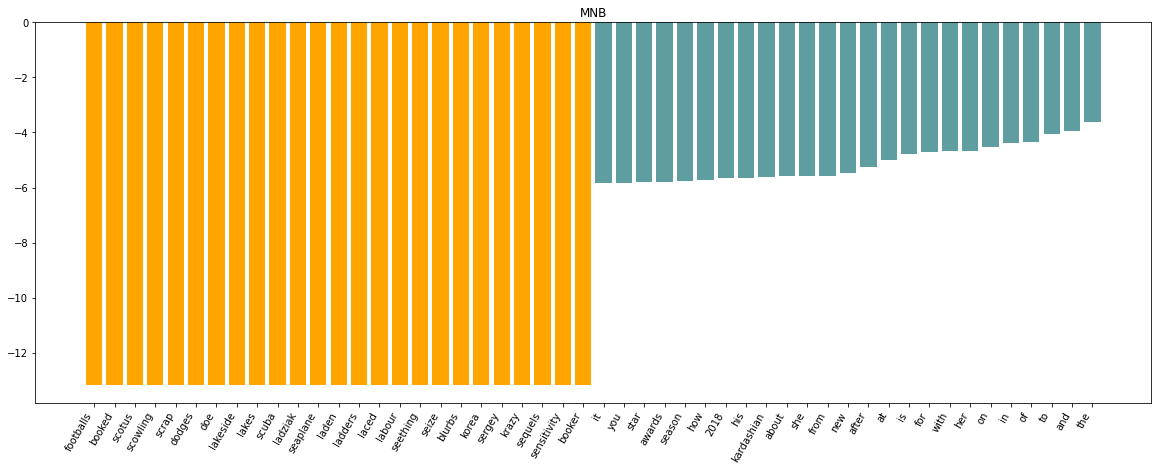

In [93]:
visualize_coefficients('MNB',
                       model_MNB,
                       vectorizer.get_feature_names())

### Final model

In [29]:
final_vect = CountVectorizer(analyzer='word', ngram_range=(1,1), min_df=2, max_df=0.5)
X = final_vect.fit_transform(x)

final_model = svm.SVC(kernel='linear').fit(X,y)

### Save model and vectorizer (with pickle)

In [15]:
# Save count_vectorizer and model into pickle file

pickle.dump(vectorizer, open("vectorizer.pk", "wb"))
pickle.dump(final_model, open("model.pkl", "wb"))